In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
import os
import datetime
import pickle

### Load and Select data from SEAScope
Select the surface velocity from 
Draw a polygon on SEAScope
Click on the extract botton on the polygon window

Note: SEAScope must be running and you must click on the "Extract granule data button" in the contextual menu.

In [2]:
from SEAScope.lib import get_extracted_data
extractions= get_extracted_data()

In [3]:
# Save a local copy
with open('data.pickle','wb') as f:
    pickle.dump(extractions,f)

In [4]:
# Load a local copy
with open('data.pickle','rb') as f:
    extractions=pickle.load(f)

In [5]:
# from SEAScope.lib import load_pyo
# data_path=''
# extractions= load_pyo(data_path)
print('\n'.join(extractions.keys()))

/media/metwally/Data/OceanTwin/seascope/data/globcurrent_l4_geostrophic/CourantGeostr_24093/CourantGeostr_24093_idf_00.nc


Print selected granules

In [6]:
for k, data in enumerate(extractions.keys()):
    print('{} - {}'.format(k,os.path.basename(data)))
    print('\n'.join(['\t{}'.format(x) for x in extractions[data]['data']]))
    print(extractions[data]['meta']['start'])

0 - CourantGeostr_24093_idf_00.nc
	eastward_geostrophic_current_velocity
	northward_geostrophic_current_velocity
2015-12-18 12:00:00


### Play with the data

Compute trajectory of fictive swell ray at initial position [x0, y0] using the dispertion relation in presence of surface current : <br>
$ \omega_c = \omega+ \vec{k}.\vec{u}$<br> 
$ \frac{dx}{dt}=\frac{d\omega_c}{dk}$<br> 
$ \frac{dk}{dt}=-\frac{d\omega_c}{d}$<br> **

In [7]:
# Get longitudes, latitudes from gcps and time from first granule
granule_uri =  next( v for i, v in enumerate(extractions.keys()) if i == 0)
extraction = extractions[granule_uri]
start = extraction['meta']['start']
print(extraction['meta']['fields'])

['eastward_geostrophic_current_velocity', 'northward_geostrophic_current_velocity']


In [8]:
name_var_u = 'eastward_geostrophic_current_velocity'
name_var_v = 'northward_geostrophic_current_velocity'

extraction = extractions[granule_uri]   
u = extraction['data'][name_var_u]
v = extraction['data'][name_var_v]

from SEAScope.lib.utils import get_lonlat
lon2D, lat2D = get_lonlat(extraction, numpy.shape(u))

In [9]:
velocity = numpy.sqrt(u**2 + v**2)
velocity.shape

(351, 572)

(351, 572) (351, 572)


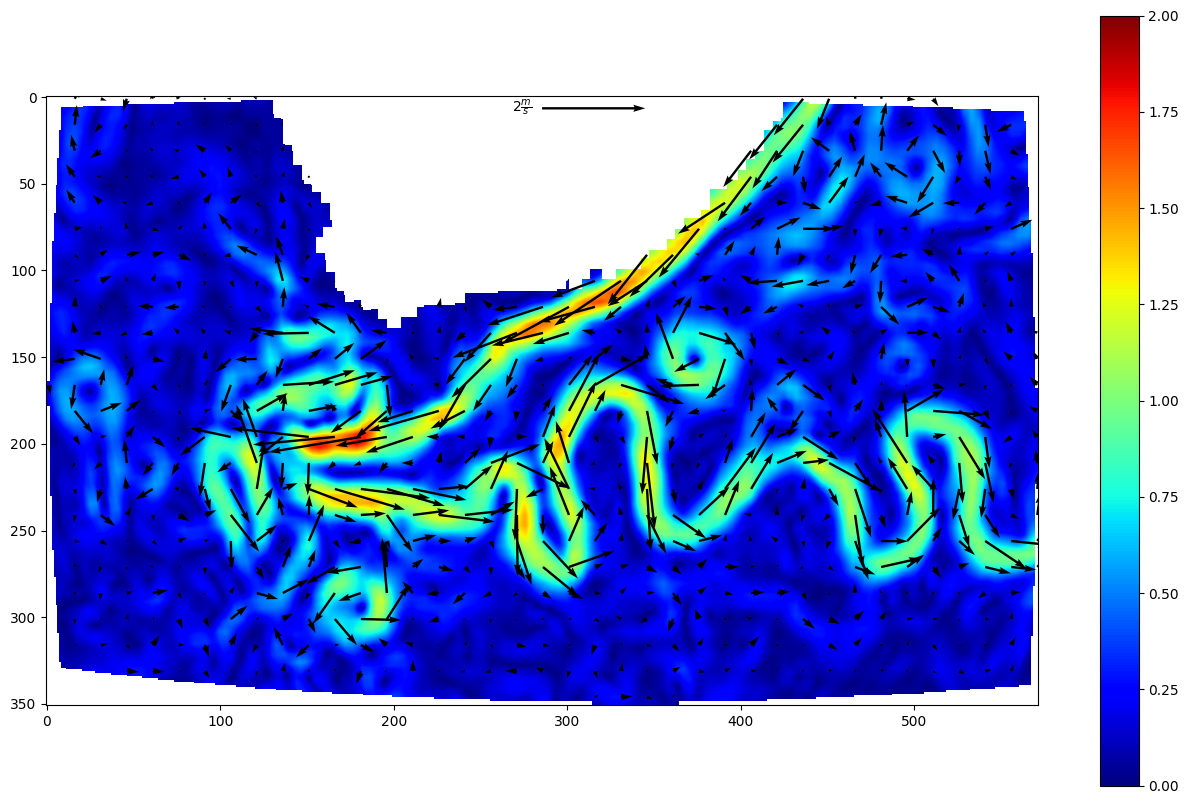

In [10]:
fig = plt.figure(figsize = (16,10))
plt.imshow(numpy.flipud(velocity), interpolation='bicubic', cmap='jet', vmin=0 , vmax=2)
cbar = plt.colorbar()
X, Y = numpy.meshgrid(numpy.arange(1, u.shape[1]+1), numpy.arange(1, u.shape[0]+1))
print(X.shape, u.shape)
Q = plt.quiver(X[::15, ::15], Y[::15, ::15],numpy.clip(numpy.flipud(u[::15,::15]),-2,2), numpy.clip(numpy.flipud(v[::15,::15]),-2,2))
qk = plt.quiverkey(Q, 0.5, 0.98, 2, r'$2 \frac{m}{s}$', labelpos='W',
                   fontproperties={'weight': 'bold'})
#plt.xlim(40, 150)
#plt.ylim(180, 120)

In [11]:
res = (lat2D[1,0] - lat2D[0,0]) * 100000
res = (lat2D[int(u.shape[0]/2 + 1), int(u.shape[1]/2)]
       - lat2D[int(u.shape[0]/2), int(u.shape[1]/2)]) * 100000
'resolution is {} m'.format(res)

'resolution is 4292.169449541916 m'

In [12]:
# Bilinear interpolation
def ev(var, x, y):
    if numpy.isnan(x) or numpy.isnan(y):
        return numpy.nan
    nx, ny = numpy.shape(var)
    i = int(x)
    j = int(y)
    if (i > nx - 2) or (j > ny - 2):
        return numpy.nan
    dx = x - i
    dy = y - j
    uix = dx * var[i + 1, j] + (1 - dx) * var[i, j]
    uiy = dx * var[i + 1, j + 1] + (1 - dx) * var[i, j + 1]
    ui = dy * uiy + (1 - dy) * uix
    return ui

# Initialize wave ray position
granule_id = None
# Time step for advection (in sec)
dt = 3600/3
# Total time of advection 
nstep = 50 #! Change this
# Number of seeds
nseed = 70 #! Change this
# Wave number
k = 2 * numpy.pi/250
# Wave direction in radians
teta0 = numpy.deg2rad(55)
# Starting line
l0 = u.shape[0] - 50
# Starting column
c0 = 50

res = (lat2D[int(u.shape[0]/2 + 1), int(u.shape[1]/2)]
       -lat2D[int(u.shape[0]/2), int(u.shape[1]/2)]) * 100000
x = numpy.full((nstep+1, nseed), numpy.nan)
y = numpy.full((nstep+1, nseed), numpy.nan)
lon = numpy.full((nstep+1, nseed), numpy.nan)
lat = numpy.full((nstep+1, nseed), numpy.nan)
for c in range(nseed):
    x[0, c] = -l0
    y[0, c] = c0 + 5*c
    lon[0, c] = ev(lon2D, x[0, c], y[0, c])
    lat[0, c] = ev(lat2D, x[0, c], y[0, c])
    teta = teta0
    kx = k * numpy.sin(teta)
    ky = k * numpy.cos(teta)
    for i in range(nstep):
        if x[i, c] is numpy.ma.masked or y[i, c] is numpy.ma.masked:
            continue
        omega = numpy.sqrt(9.81 * (kx**2+ky**2)) + (kx*ev(u,x[i, c], y[i, c])
                           + ky * ev(v, x[i, c], y[i, c]))
        dx = dt * (ev(u, x[i, c], y[i, c]) + numpy.sqrt(9.81/(numpy.sqrt(kx**2+ky**2)))
                 * numpy.sin(teta))/res
        dy = dt * (ev(v, x[i, c], y[i, c]) + numpy.sqrt(9.81/(numpy.sqrt(kx**2+ky**2)))
                 *numpy.cos(teta))/res
        teta = numpy.arctan(dx/dy)
        if dx is numpy.ma.masked or dy is numpy.ma.masked:
            continue
        domegax = omega - (numpy.sqrt(9.81 * (kx**2+ky**2))
                           + (kx * ev(u, x[i, c] + dx, y[i, c])
                           + ky * ev(v, x[i, c] + dx, y[i, c])))
        domegay = omega - (numpy.sqrt(9.81 * (kx**2+ky**2))
                           + (kx * ev(u, x[i, c], y[i, c] + dy)
                           + ky * ev(v, x[i, c], y[i, c] + dy)))

        x[i + 1, c] = x[i, c] + dx
        y[i + 1, c] = y[i, c] + dy
        lon[i + 1, c] = ev(lon2D, x[i + 1, c], y[i + 1, c])
        lat[i + 1, c] = ev(lat2D, x[i + 1, c], y[i + 1, c])
        dkx = dt * domegax/dx/25000
        dky = dt * domegay/dy/25000
        kx = kx + dkx
        ky = ky + dky

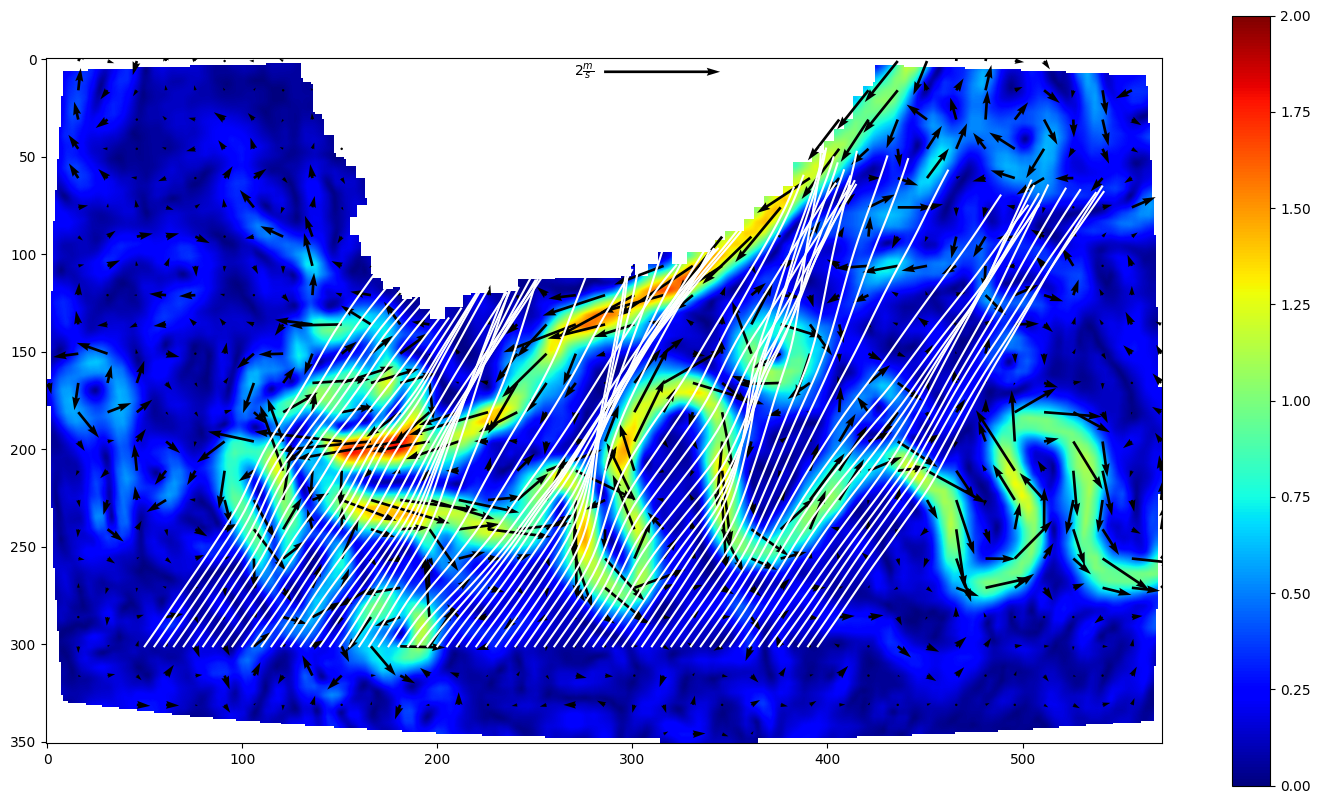

In [13]:
fig = plt.figure(figsize = (18,10))
plt.imshow(numpy.flipud(velocity),interpolation='bicubic',cmap='jet', vmin=0 , vmax=2)
cbar=plt.colorbar()
Q = plt.quiver(X[::15, ::15], Y[::15, ::15],
               numpy.clip(numpy.flipud(u[::15, ::15]), -2, 2),
               numpy.clip(numpy.flipud(v[::15, ::15]), -2, 2))
qk = plt.quiverkey(Q, 0.5, 0.98, 2, r'$2 \frac{m}{s}$', labelpos='W',
                   fontproperties={'weight': 'bold'})
for c in range(nseed):
    plt.plot(y[:, c],-x[:, c], color='w', linewidth=1.5)
